# 10. Linear Regression

This chapter will introduce you to **linear regression** analysis using R.

### Linear Regression Basics

#### Linear Regression Equation in matrix form

$$ Y = X\beta + \epsilon $$

#### Model Assumption

The assumptions of linear regression are important to ensure the validity and reliability of the model. Here are five key assumptions:

- Linearity: The relationship between the independent variables and the dependent variable is linear. This means that the change in the dependent variable is proportional to the change in the independent variable(s). It is essential to check for linearity by examining scatter plots or performing diagnostic tests.

- Independence: The observations in the dataset are assumed to be independent of each other. There should be no systematic relationship or correlation between the residuals (the differences between the predicted and observed values). Independence can be violated when there is autocorrelation or when observations are clustered or dependent on each other.

- Homoscedasticity: The variance of the residuals is constant across all levels of the independent variables. In other words, the spread or dispersion of the residuals should remain consistent throughout the range of the independent variable(s). Violations of homoscedasticity, called heteroscedasticity, can lead to biased standard errors and incorrect hypothesis tests.

- Normality: The residuals follow a normal distribution. This assumption allows for valid hypothesis testing, confidence interval estimation, and prediction intervals. Departures from normality can affect the accuracy of statistical inferences, especially when dealing with small sample sizes. However, the central limit theorem helps to mitigate minor departures from normality in large samples.

- No multicollinearity: The independent variables should not be highly correlated with each other. High multicollinearity can lead to unstable and unreliable estimates of the coefficients. It becomes challenging to distinguish the individual effects of the independent variables, and the interpretation of the model becomes problematic. Detecting multicollinearity can be done using correlation matrices or variance inflation factor (VIF) calculations.

We'll discuss how to check these assumptions with R in the later section.

### Linear Regression in R

In [35]:
library('RforHDSdata')
library('broom')
library('MASS')
library('tidyverse')
library('car')

In [9]:
library('RforHDSdata')

#### EDA

Just like we did in Chapter 4, we will first do some EDA and fill in the missing values.

In [10]:
data(NHANESsample)
dim(NHANESsample)
names(NHANESsample)

[1] 31265    21

[1] "ID"            "AGE"           "SEX"           "RACE"         
 [5] "EDUCATION"     "INCOME"        "SMOKE"         "YEAR"         
 [9] "LEAD"          "BMI_CAT"       "LEAD_QUANTILE" "HYP"          
[13] "ALC"           "DBP1"          "DBP2"          "DBP3"         
[17] "DBP4"          "SBP1"          "SBP2"          "SBP3"         
[21] "SBP4"

In [11]:
sum(complete.cases(NHANESsample))
apply(NHANESsample, 2, function(x) sum(is.na(x)))/nrow(NHANESsample)

[1] 0

ID           AGE           SEX          RACE     EDUCATION 
 0.0000000000  0.0000000000  0.0000000000  0.0000000000  0.0006716776 
       INCOME         SMOKE          YEAR          LEAD       BMI_CAT 
 0.0000000000  0.0000000000  0.0000000000  0.0000000000  0.0000000000 
LEAD_QUANTILE           HYP           ALC          DBP1          DBP2 
 0.0000000000  0.0000000000  0.0268671038  0.0600351831  0.0639053254 
         DBP3          DBP4          SBP1          SBP2          SBP3 
 0.0709739325  0.8911242604  0.0600351831  0.0639053254  0.0709419479 
         SBP4 
 0.8911242604

In [12]:
nhanes_df <- na.omit(subset(NHANESsample, select= -c(SBP2, SBP3, SBP4, DBP2, DBP3, DBP4)))

In [13]:
nhanes_df <- subset(nhanes_df, nhanes_df$YEAR==2017)

In [14]:
head(nhanes_df)

,ID,AGE,SEX,RACE,EDUCATION,INCOME,SMOKE,YEAR,LEAD,BMI_CAT,LEAD_QUANTILE,HYP,ALC,DBP1,SBP1
,<dbl>,<dbl>,<fct>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<chr>,<dbl>,<dbl>
27663,93711,56,Male,Other Race,MoreThanHS,5.00,NeverSmoke,2017,2.15,BMI<=25,Q3,0,Yes,68,108
27664,93713,67,Male,Non-Hispanic White,HS,2.65,StillSmoke,2017,3.71,BMI<=25,Q4,0,Yes,70,104
27667,93716,61,Male,Other Race,MoreThanHS,5.00,QuitSmoke,2017,1.99,BMI>=30,Q3,0,Yes,72,120
27668,93717,22,Male,Non-Hispanic White,HS,1.49,StillSmoke,2017,1.93,BMI<=25,Q3,0,Yes,62,116
27670,93721,60,Female,Mexican American,LessThanHS,3.04,NeverSmoke,2017,0.75,BMI>=30,Q1,1,Yes,68,132
27671,93722,60,Female,Non-Hispanic White,MoreThanHS,2.07,NeverSmoke,2017,0.98,BMI<=25,Q2,0,Yes,68,116


#### Plotting the independent and response variables

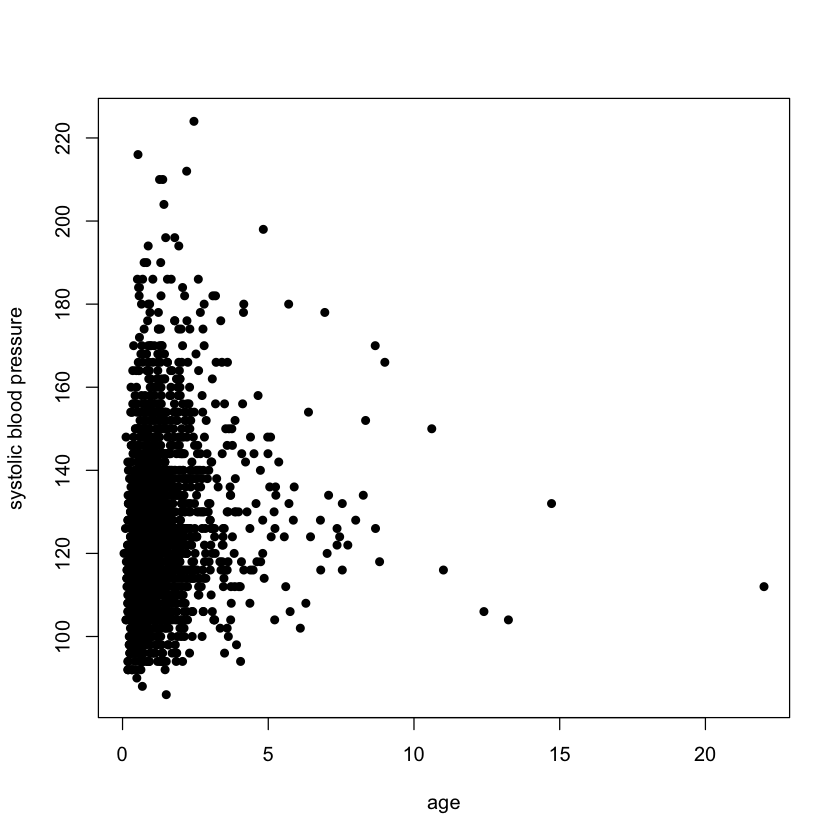

In [15]:
SBP1 <- nhanes_df$SBP1
AGE <- nhanes_df$LEAD

plot(SBP1~AGE,ylab=c("systolic blood pressure"),xlab=c("age"),pch=16)

From the scatterplot, we could see a roughly linear relationship between SBP1 and age

#### Using the basic linear regression function in R

Now fit a regression line to explain the association between upper leg length and height.

The function in R is lm(formula = y ~ x, data)

In [16]:
model <- lm(formula = SBP1~AGE, data = nhanes_df)
summary(model)


Call:
lm(formula = SBP1 ~ AGE, data = nhanes_df)

Residuals:
    Min      1Q  Median      3Q     Max 
-43.832 -10.851  -1.599   8.707  96.194 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 101.54722    0.97265  104.40   <2e-16 ***
AGE           0.47743    0.01898   25.15   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 16.47 on 2582 degrees of freedom
Multiple R-squared:  0.1968,	Adjusted R-squared:  0.1965 
F-statistic: 632.7 on 1 and 2582 DF,  p-value: < 2.2e-16


Next plot the estimtated regression line over the scatterplot.

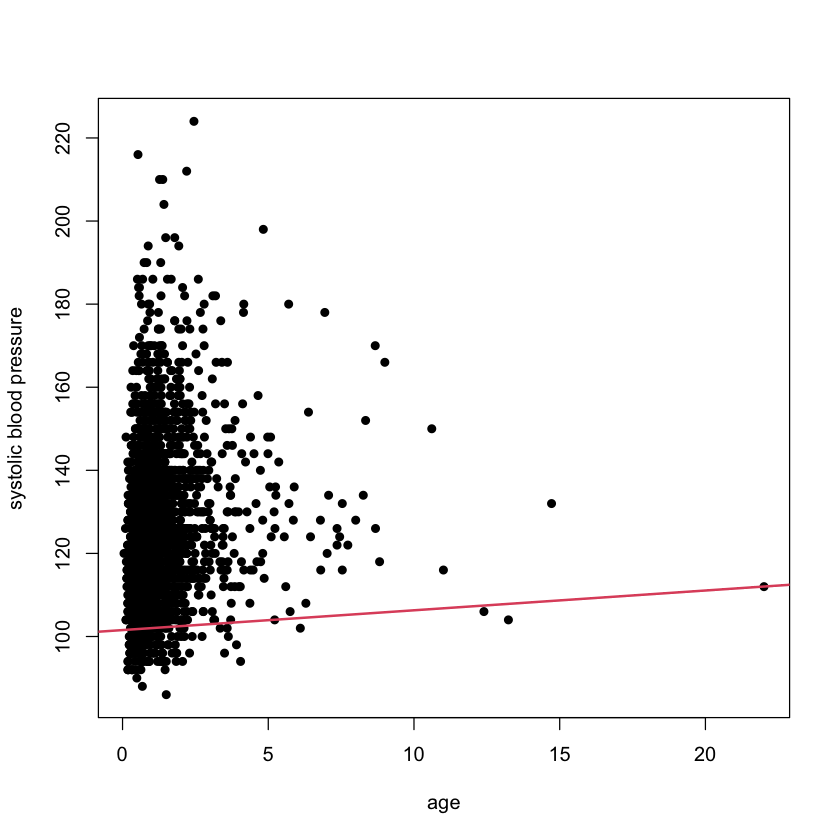

In [17]:
plot(SBP1~AGE,ylab=c("systolic blood pressure"),xlab=c("age"),pch=16)
abline(model,col=2,lwd=2)

#### Intepretating Linear Regression Result

We can also extract the regression coefficients from the lm() using the following commands, it shows the estimate, standard error, statistic, and p-value of each coefficient in a clean table.

In [18]:
tidy(model)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),101.5472233,0.97265476,104.40212,0.000000e+00
AGE,0.4774284,0.01898122,25.15266,4.709657e-125


#### With categorical variables

We can also examine the relationship between a new feature we created in chapter 4, EVER_SMOKE-a categorical variable represented by numbers, and body height using the function factor().

In [19]:
nhanes_df$EVER_SMOKE <- ifelse(nhanes_df$SMOKE %in% c("QuitSmoke", "StillSmoke"), "Yes", "No")
table(nhanes_df$EVER_SMOKE)


  No  Yes 
1411 1173 

In [20]:
EVER_SMOKE <- nhanes_df$EVER_SMOKE

In [21]:
model2 <- lm(formula = SBP1~factor(EVER_SMOKE), data = nhanes_df)
summary(model2)


Call:
lm(formula = SBP1 ~ factor(EVER_SMOKE), data = nhanes_df)

Residuals:
    Min      1Q  Median      3Q     Max 
-37.436 -13.436  -2.032   9.968  97.968 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)           123.4359     0.4881 252.905  < 2e-16 ***
factor(EVER_SMOKE)Yes   2.5965     0.7244   3.584 0.000344 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 18.33 on 2582 degrees of freedom
Multiple R-squared:  0.004951,	Adjusted R-squared:  0.004566 
F-statistic: 12.85 on 1 and 2582 DF,  p-value: 0.0003442


In order to consider height, upper leg length, and body measures component status code, we can start by creating a scatterplot of height versus upper leg lenth, stratified by body measures component status code.

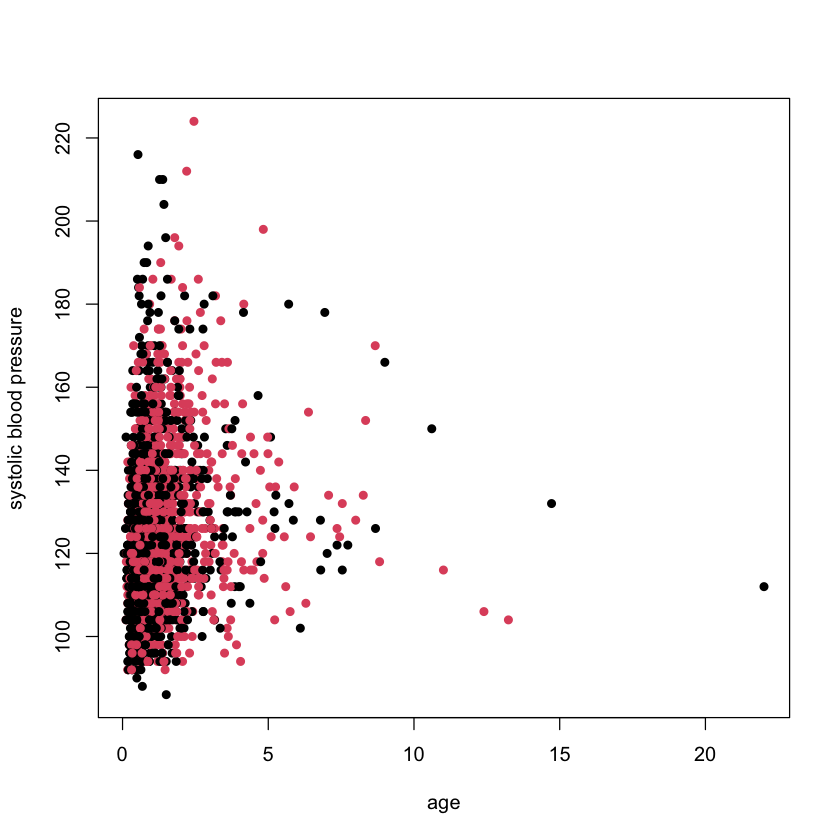

In [22]:
colvec <- c(1,2) # here define values to define color in plot below 
plot(AGE, SBP1, pch=16, col = colvec[factor(EVER_SMOKE)], xlab="age",ylab="systolic blood pressure")

Now lets fit a model to predict SBP1 based on AGE and EVER_SMOKE.

In [23]:
model3 <- lm(formula = SBP1~factor(EVER_SMOKE) + AGE, data = nhanes_df)
summary(model3)


Call:
lm(formula = SBP1 ~ factor(EVER_SMOKE) + AGE, data = nhanes_df)

Residuals:
    Min      1Q  Median      3Q     Max 
-44.087 -10.795  -1.549   8.828  95.895 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)           101.38734    0.98977 102.436   <2e-16 ***
factor(EVER_SMOKE)Yes   0.57304    0.65594   0.874    0.382    
AGE                     0.47535    0.01913  24.848   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 16.47 on 2581 degrees of freedom
Multiple R-squared:  0.197,	Adjusted R-squared:  0.1964 
F-statistic: 316.7 on 2 and 2581 DF,  p-value: < 2.2e-16


Last, let’s look at estimating a 95% confidence interval for the coefficient for upper leg length. We can do it by using the function confint()

Note that the function confint() will give confidence interval to all coefficients, including categorical variables.

In [24]:
ci <- confint(model3, level = 0.95)
ci

,2.5 %,97.5 %
(Intercept),99.4465225,103.3281568
factor(EVER_SMOKE)Yes,-0.7131809,1.8592583
AGE,0.4378417,0.5128654


#### Checking Model Assumptions with R

R has some built-in plots available for a linear regression model. We plot these below. The four plots include (a) Residuals vs Fitted, (b) QQ-plot, (c) Standardized residuals (sqrt) vs Fitted, and (d) Standardized residuals vs leverage. In the last plot, you may observe that there is a dashed line. Any points outside of these lines have a Cook’s distance of greater than 0.5. Additionally, points with labels correspond to the points with the largest residuals. So this last plot tries to summarize the outliers, leverage, and influential
points.


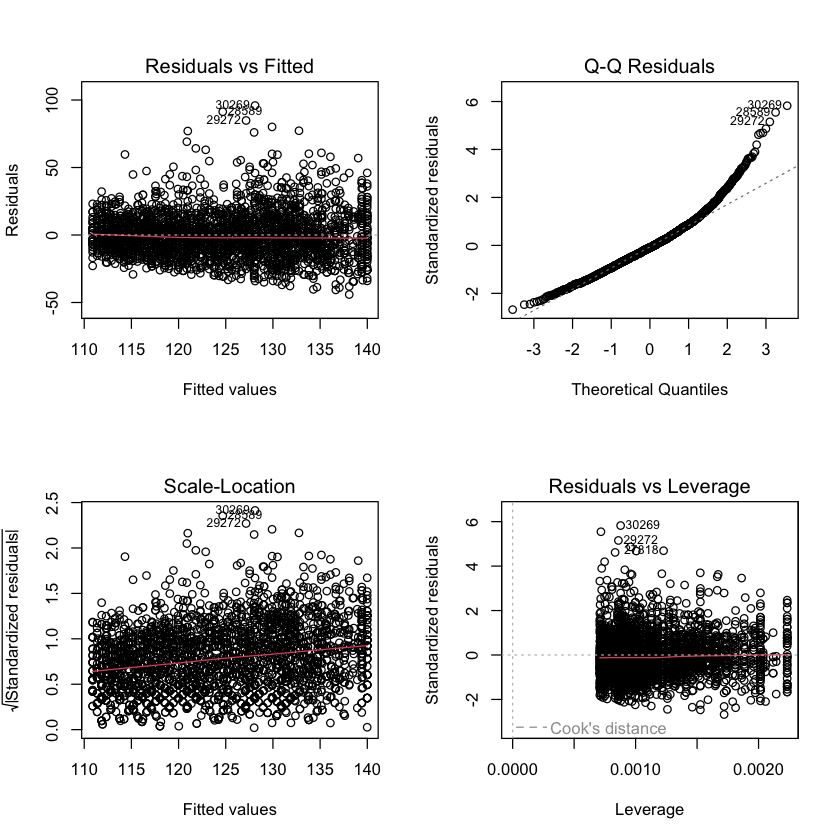

In [25]:
par(mfrow=c(2,2)) # for formatting
plot(model3)

##### Normality

As both the histogram and qq plot shown, the residuals are positive-skewed, and thus Normality is not satisfied, we will introduce how we might transform this dataset to satisfy this assumption later in this chapter.

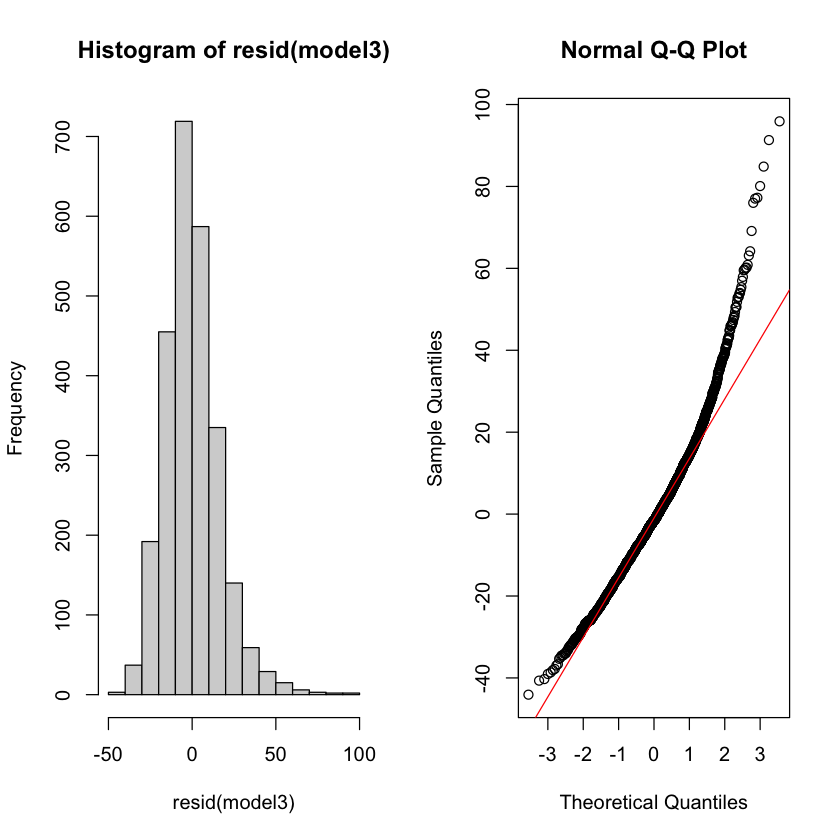

In [26]:
par(mfrow=c(1,2)) # for formatting
hist(resid(model3)) # hist() is used to plot histogram, resid() is used to get residuals of the model
qqnorm(resid(model3)) # qqnorm() is used to plot qq plot
qqline(resid(model3),col="red") # qqline is used to draw the normal qq line as reference

We could also check normality without using the function resid(). We could calculate the standardized residual using the function rstandard(), and then use the standardized residual to check.

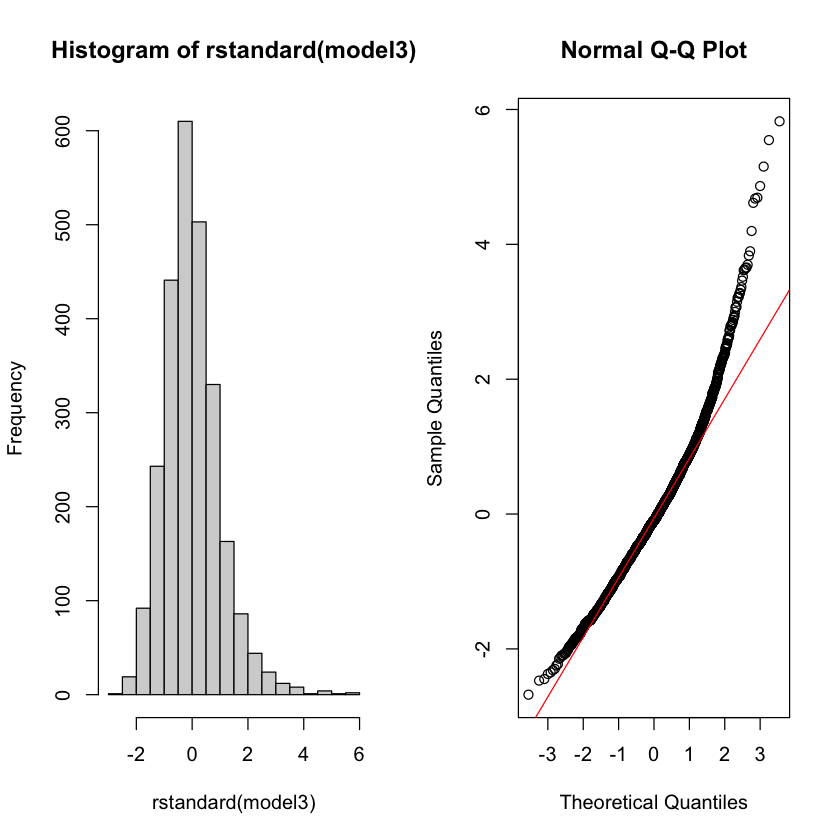

In [27]:
par(mfrow=c(1,2)) 
hist(rstandard(model3)) 
qqnorm(rstandard(model3)) 
qqline(rstandard(model3),col="red")

##### homoscedasticity and Linearity

The fitted vs. residual plot is spread roughly evenly around 0 and has no discerning pattern, and thus fit the linearity assumption. However, the residual vs. fitted value graph shows a tunnel shape, indicating a shrinking variance of residuals, and is thus, violating homoscedasticity assumption.

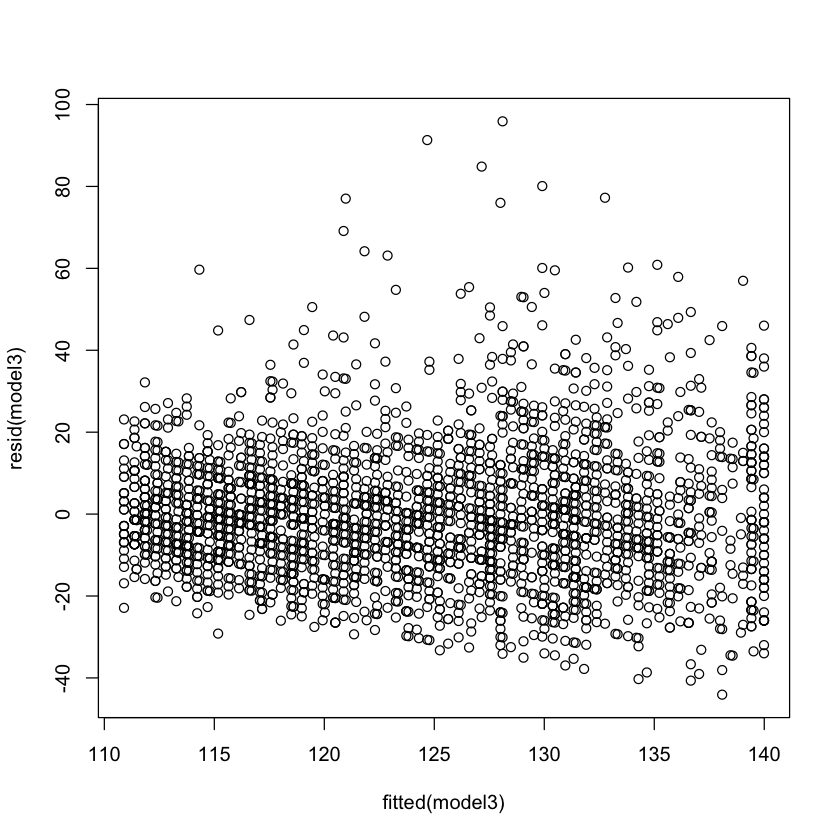

In [28]:
par(mfrow=c(1,1))
plot(fitted(model3), resid(model3))

##### collinearity

VIF = 1 → complete absence of collinearity 

VIF ≥ 5 or 10 → problematic amount of collinearity

In [29]:
vif(model3)

factor(EVER_SMOKE)                AGE 
          1.015654           1.015654

##### leverage

Leverage values measure how much an individual observation's predictor values differ from the average predictor values in the dataset. High leverage values indicate that an observation has extreme predictor values compared to the rest of the data.

Leverage values range from 0 to 1, with higher values indicating greater influence. Observations with high leverage have the potential to significantly impact the estimated regression coefficients and the overall fit of the model. Therefore, examining leverage values helps identify observations that may be influential or outliers.

In [50]:
head(hatvalues(model3))

27663        27664        27667        27668        27670        27671 
0.0008334447 0.0012134878 0.0009972654 0.0019588174 0.0009587846 0.0009587846

The influence.measures() function provides a set of measures that quantify the influence of each observation on a linear regression model. These measures include Cook's distance, standardized residuals, and studentized residuals, among others.
- Cook's distance measures the influence of an observation on the overall model fit. Large values of Cook's distance suggest that removing that observation would have a substantial effect on the estimated coefficients.
- Standardized residuals measure the difference between the observed and predicted values, scaled by the standard deviation of the residuals. Outlying observations often exhibit large standardized residuals.
- Studentized residuals are similar to standardized residuals, but they are scaled by the estimated standard deviation of the residuals, accounting for the influence of each observation on its own predicted value.

In [59]:
inflm <- influence.measures(model3)

inflm.df <-
  as.data.frame(inflm[["infmat"]]) %>%
  tibble::remove_rownames() %>%
  dplyr::mutate(inf = ifelse(row_number() %in% unname(which(
    apply(inflm$is.inf, 1, any)
  )), "*", "")) # converting infl to data frame format for easier access

ERROR: Error in as.data.frame(inflm[["infmat"]]) %>% tibble::remove_rownames() %>% : could not find function "%>%"


### Interactive Term

To capture the interaction between two terms, suppose AGE and EVER_SMOKE, we could use the function shown below

In [60]:
model5 <- lm(SBP1 ~ factor(EVER_SMOKE) + AGE + EVER_SMOKE:AGE, data=nhanes_df)
summary(model5)


Call:
lm(formula = SBP1 ~ factor(EVER_SMOKE) + AGE + EVER_SMOKE:AGE, 
    data = nhanes_df)

Residuals:
    Min      1Q  Median      3Q     Max 
-43.380 -10.779  -1.481   8.792  96.017 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)           100.33805    1.27204  78.879   <2e-16 ***
factor(EVER_SMOKE)Yes   3.03405    1.98589   1.528    0.127    
AGE                     0.49798    0.02574  19.343   <2e-16 ***
AGE:EVER_SMOKEYes      -0.05050    0.03846  -1.313    0.189    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 16.47 on 2580 degrees of freedom
Multiple R-squared:  0.1976,	Adjusted R-squared:  0.1966 
F-statistic: 211.8 on 3 and 2580 DF,  p-value: < 2.2e-16


### Transformation

Sometimes when the original data doesn't fit the linear regression assumptions, we could transform either the predictor or the outcome.

##### log-linear transform the outcome

In [63]:
model6 <- lm(log(SBP1) ~ AGE, data=nhanes_df) 
summary(model6)


Call:
lm(formula = log(SBP1) ~ AGE, data = nhanes_df)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.37448 -0.08216 -0.00528  0.07695  0.57181 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 4.6356931  0.0074409  623.00   <2e-16 ***
AGE         0.0037116  0.0001452   25.56   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.126 on 2582 degrees of freedom
Multiple R-squared:  0.2019,	Adjusted R-squared:  0.2016 
F-statistic: 653.4 on 1 and 2582 DF,  p-value: < 2.2e-16


Before transformation, the linear model is stored in model3, and the distribution is shown below

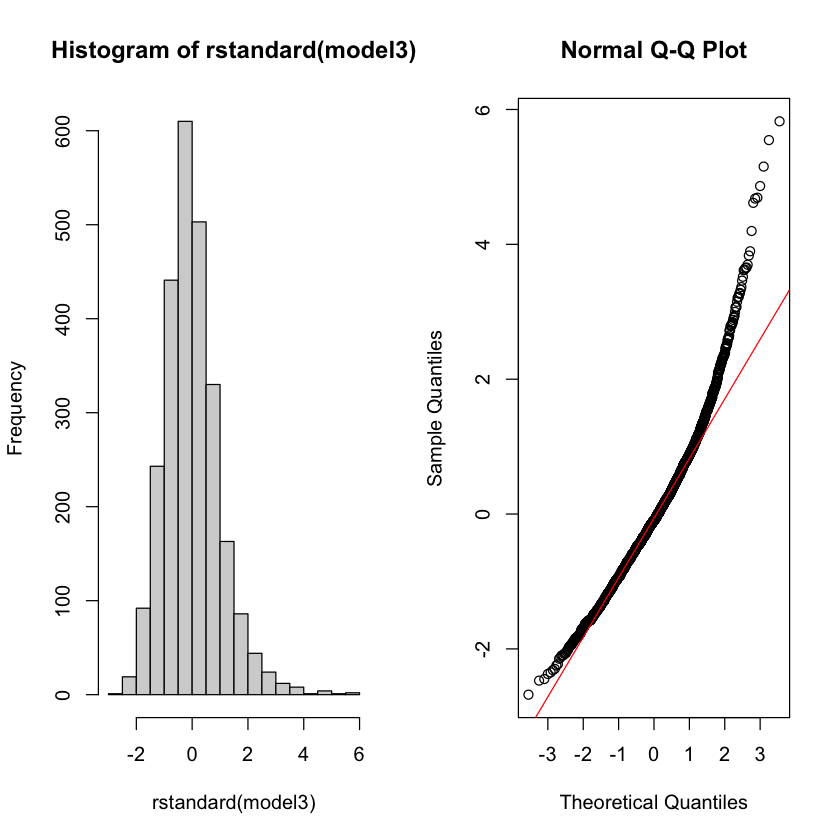

In [65]:
par(mfrow=c(1,2)) 
hist(rstandard(model3)) 
qqnorm(rstandard(model3)) 
qqline(rstandard(model3),col="red")

After the transformation, the new linear model is stored in model6, and we could see that the distribution is less skewed than before

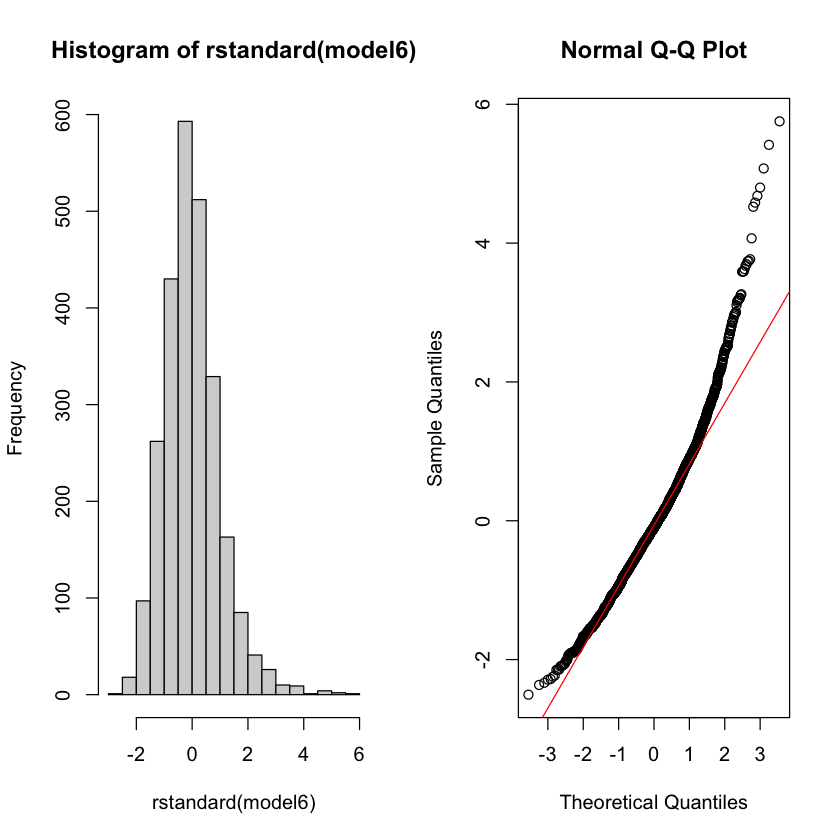

In [70]:
par(mfrow=c(1,2)) 
hist(rstandard(model6)) 
qqnorm(rstandard(model6)) 
qqline(rstandard(model6),col="red")

##### linear-log transform the predictor

In [67]:
model7 <- lm(SBP1 ~ I(log(AGE)), data=nhanes_df) 
summary(model7)


Call:
lm(formula = SBP1 ~ I(log(AGE)), data = nhanes_df)

Residuals:
    Min      1Q  Median      3Q     Max 
-41.461 -10.839  -1.522   8.779  95.256 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  45.5204     3.2466   14.02   <2e-16 ***
I(log(AGE))  20.7679     0.8482   24.48   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 16.56 on 2582 degrees of freedom
Multiple R-squared:  0.1884,	Adjusted R-squared:  0.1881 
F-statistic: 599.5 on 1 and 2582 DF,  p-value: < 2.2e-16


We can check linear-log transform as well

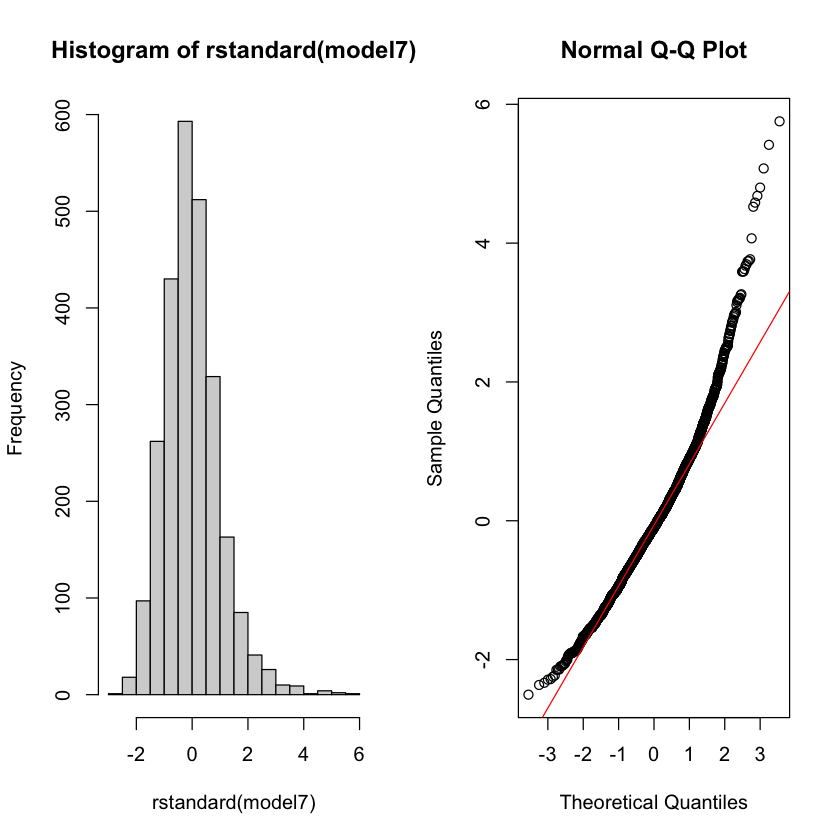

In [71]:
par(mfrow=c(1,2)) 
hist(rstandard(model7)) 
qqnorm(rstandard(model7)) 
qqline(rstandard(model7),col="red")

##### log-log transform the predictor and outcome

In [68]:
model8 <- lm(log(SBP1) ~ log(AGE), data=nhanes_df) 
summary(model8)


Call:
lm(formula = log(SBP1) ~ log(AGE), data = nhanes_df)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.35628 -0.08239 -0.00494  0.07670  0.56443 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 4.198470   0.024825  169.12   <2e-16 ***
log(AGE)    0.161890   0.006485   24.96   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1266 on 2582 degrees of freedom
Multiple R-squared:  0.1944,	Adjusted R-squared:  0.1941 
F-statistic: 623.1 on 1 and 2582 DF,  p-value: < 2.2e-16


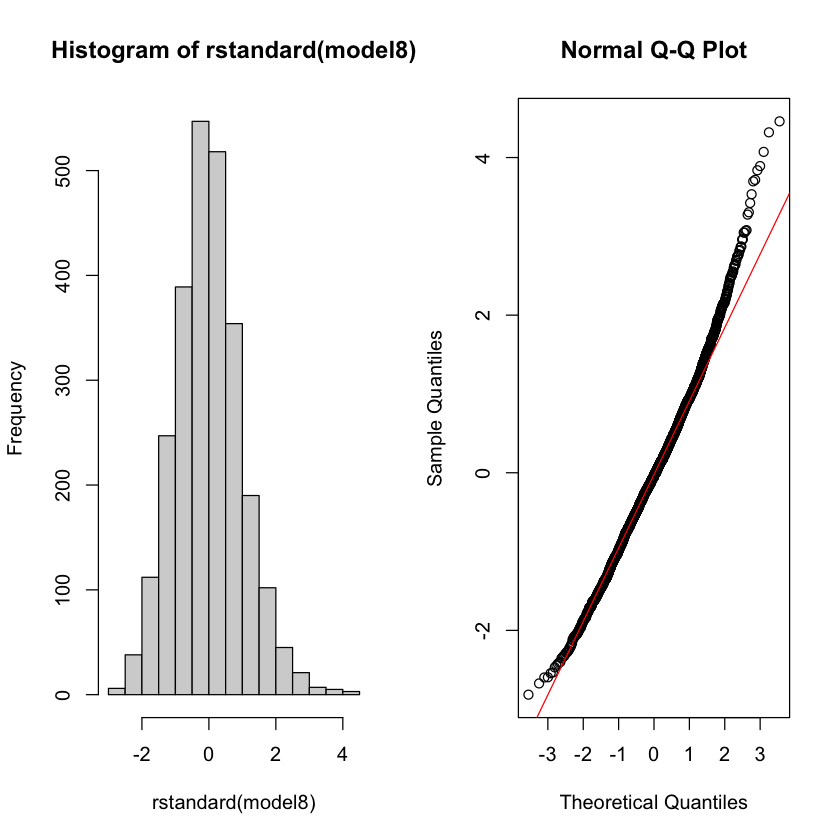

In [72]:
par(mfrow=c(1,2)) 
hist(rstandard(model8)) 
qqnorm(rstandard(model8)) 
qqline(rstandard(model8),col="red")

### Evaluation Metrics

There are multiple ways we could use to evaluate the performace of our model

##### Getting the predicted value

We will be using model 8, after log-log transformation to satisfy normality assumption, as our final model 

In [79]:
predicted <- predict(model8)
head(predicted)

27663    27664    27667    27668    27670    27671 
4.850133 4.879167 4.863979 4.698878 4.861303 4.861303

##### MAE

MAE measures the average absolute difference between the predicted values and the actual values. It provides a straightforward way to assess the average magnitude of errors in a predictive model. MAE is less sensitive to outliers compared to other error metrics such as MSE. It is commonly used in regression and forecasting tasks to quantify the average deviation between predicted and observed values.

In [80]:
mae <- mean(abs(SBP1 - predicted))
mae

[1] 119.7995

##### MSE

MSE calculates the average of the squared differences between predicted values and actual values. It is widely used as an error metric for regression tasks. Squaring the errors amplifies larger errors, making MSE more sensitive to outliers than MAE. MSE is often used in model training as an objective function to be minimized, and it provides a measure of the average variance between predicted and observed values.

In [81]:
mse <- mean((SBP1- predicted)^2)
mse

[1] 14688.47

##### AIC

AIC is a criterion used for model selection, especially in the context of statistical modeling. It balances the trade-off between model complexity and goodness of fit. AIC takes into account both the goodness of fit (captured by the likelihood of the model) and the complexity of the model (captured by the number of parameters used). Lower AIC values indicate a better trade-off between model complexity and fit. It is often used in regression, time series analysis, and other statistical modeling tasks.

In [82]:
AIC(model8)

[1] -3343.643

##### BIC

BIC, similar to AIC, is a criterion used for model selection. It provides a more stringent penalty for model complexity compared to AIC. BIC incorporates the likelihood of the model, the number of parameters used, and the sample size. BIC tends to penalize more complex models compared to AIC, which makes it useful for preventing overfitting. Lower BIC values indicate better-fitting models. Like AIC, BIC is commonly used in regression, time series analysis, and other statistical modeling tasks.

In [83]:
BIC(model8)

[1] -3326.071

### Feature Selection 

When there are a lot of variables to choose from, there are multiple ways we could choose which features to use 

In [85]:
head(nhanes_df)

,ID,AGE,SEX,RACE,EDUCATION,INCOME,SMOKE,YEAR,LEAD,BMI_CAT,LEAD_QUANTILE,HYP,ALC,DBP1,SBP1,EVER_SMOKE
,<dbl>,<dbl>,<fct>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<chr>,<dbl>,<dbl>,<chr>
27663,93711,56,Male,Other Race,MoreThanHS,5.00,NeverSmoke,2017,2.15,BMI<=25,Q3,0,Yes,68,108,No
27664,93713,67,Male,Non-Hispanic White,HS,2.65,StillSmoke,2017,3.71,BMI<=25,Q4,0,Yes,70,104,Yes
27667,93716,61,Male,Other Race,MoreThanHS,5.00,QuitSmoke,2017,1.99,BMI>=30,Q3,0,Yes,72,120,Yes
27668,93717,22,Male,Non-Hispanic White,HS,1.49,StillSmoke,2017,1.93,BMI<=25,Q3,0,Yes,62,116,Yes
27670,93721,60,Female,Mexican American,LessThanHS,3.04,NeverSmoke,2017,0.75,BMI>=30,Q1,1,Yes,68,132,No
27671,93722,60,Female,Non-Hispanic White,MoreThanHS,2.07,NeverSmoke,2017,0.98,BMI<=25,Q2,0,Yes,68,116,No


In [93]:
fit.all <- lm(SBP1 ~ AGE + factor(SEX) + factor(RACE) + factor(EDUCATION) +
              INCOME + factor(EVER_SMOKE) + LEAD + factor(BMI_CAT) +
              factor(HYP) + DBP1 + factor(LEAD_QUANTILE), data =nhanes_df)
intercept_only <- lm(SBP1 ~ 1, data = nhanes_df)

##### forward selection

In [94]:
step(intercept_only, direction = 'forward', scope=formula(fit.all))

Start:  AIC=15045.17
SBP1 ~ 1

                        Df Sum of Sq    RSS   AIC
+ factor(HYP)            1    303873 568311 13940
+ AGE                    1    171649 700535 14481
+ DBP1                   1    151430 720754 14554
+ factor(LEAD_QUANTILE)  3     51267 820917 14895
+ LEAD                   1     22183 850001 14981
+ factor(BMI_CAT)        2     19790 852394 14990
+ factor(RACE)           4     17740 854444 15000
+ factor(SEX)            1     13666 858518 15006
+ factor(EDUCATION)      2      5000 867184 15034
+ factor(EVER_SMOKE)     1      4318 867866 15034
+ INCOME                 1      1374 870811 15043
<none>                               872184 15045

Step:  AIC=13940.36
SBP1 ~ factor(HYP)

                        Df Sum of Sq    RSS   AIC
+ AGE                    1     39286 529025 13757
+ DBP1                   1     39285 529026 13757
+ factor(LEAD_QUANTILE)  3     11863 556448 13892
+ factor(RACE)           4      7976 560335 13912
+ LEAD                   1  


Call:
lm(formula = SBP1 ~ factor(HYP) + AGE + DBP1 + factor(RACE) + 
    INCOME, data = nhanes_df)

Coefficients:
                   (Intercept)                    factor(HYP)1  
                       75.6294                         13.0856  
                           AGE                            DBP1  
                        0.3226                          0.3966  
    factor(RACE)Other Hispanic  factor(RACE)Non-Hispanic White  
                       -1.5979                         -1.7099  
factor(RACE)Non-Hispanic Black          factor(RACE)Other Race  
                        2.2043                         -2.3157  
                        INCOME  
                       -0.7732  


##### backward selection

In [95]:
backward <- step(fit.all, direction='backward')

Start:  AIC=13418.57
SBP1 ~ AGE + factor(SEX) + factor(RACE) + factor(EDUCATION) + 
    INCOME + factor(EVER_SMOKE) + LEAD + factor(BMI_CAT) + factor(HYP) + 
    DBP1 + factor(LEAD_QUANTILE)

                        Df Sum of Sq    RSS   AIC
- factor(LEAD_QUANTILE)  3       525 458850 13416
- LEAD                   1        21 458346 13417
- factor(SEX)            1        62 458387 13417
- factor(EDUCATION)      2       419 458744 13417
- factor(EVER_SMOKE)     1       200 458525 13418
- factor(BMI_CAT)        2       569 458894 13418
<none>                               458325 13419
- INCOME                 1      2625 460950 13431
- factor(RACE)           4      6442 464767 13447
- AGE                    1     46298 504623 13665
- DBP1                   1     53980 512305 13704
- factor(HYP)            1     68718 527043 13778

Step:  AIC=13415.53
SBP1 ~ AGE + factor(SEX) + factor(RACE) + factor(EDUCATION) + 
    INCOME + factor(EVER_SMOKE) + LEAD + factor(BMI_CAT) + factor(HYP) + 


##### both

In [96]:
backward <- step(fit.all, direction='both')

Start:  AIC=13418.57
SBP1 ~ AGE + factor(SEX) + factor(RACE) + factor(EDUCATION) + 
    INCOME + factor(EVER_SMOKE) + LEAD + factor(BMI_CAT) + factor(HYP) + 
    DBP1 + factor(LEAD_QUANTILE)

                        Df Sum of Sq    RSS   AIC
- factor(LEAD_QUANTILE)  3       525 458850 13416
- LEAD                   1        21 458346 13417
- factor(SEX)            1        62 458387 13417
- factor(EDUCATION)      2       419 458744 13417
- factor(EVER_SMOKE)     1       200 458525 13418
- factor(BMI_CAT)        2       569 458894 13418
<none>                               458325 13419
- INCOME                 1      2625 460950 13431
- factor(RACE)           4      6442 464767 13447
- AGE                    1     46298 504623 13665
- DBP1                   1     53980 512305 13704
- factor(HYP)            1     68718 527043 13778

Step:  AIC=13415.53
SBP1 ~ AGE + factor(SEX) + factor(RACE) + factor(EDUCATION) + 
    INCOME + factor(EVER_SMOKE) + LEAD + factor(BMI_CAT) + factor(HYP) + 


#### reorder()

We can use reorder() to redefine our reference level

In [99]:
vec <- factor(c("c", "b", "a"))  
vec

[1] c b a
Levels: a b c

In [102]:
vec_reorder <- reorder(vec, c(2, 3, 1)) # Apply reorder function to vector
vec_reorder  

[1] c b a
attr(,"scores")
a b c 
1 3 2 
Levels: a c b